In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy scikit-learn
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
cn_path = "histogram_features_all_subjects"
ad_path = "histogram_features_all_subjects"

cn_features_dict = np.load(cn_path, allow_pickle=True).item()
ad_features_dict = np.load(ad_path, allow_pickle=True).item()

cn_features = np.array(list(cn_features_dict.values()))
ad_features = np.array(list(ad_features_dict.values()))

# Labels: 0 for CN, 1 for AD
cn_labels = np.zeros(cn_features.shape[0])
ad_labels = np.ones(ad_features.shape[0])

X = np.vstack((cn_features, ad_features))
y = np.hstack((cn_labels, ad_labels))
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for transformer input
X_seq = X.reshape(X.shape[0], 180, 1)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

# Define Transformer model
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=1, model_dim=32, num_classes=2, num_heads=8, ff_dim=128, dropout=0.3, max_len=180):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, model_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.classifier(x)

# Train and evaluate
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)
num_epochs = 2500
accuracies, precisions, recalls, f1_scores, losses, all_auc = [], [], [], [], [], []
all_y_true, all_y_proba, all_fpr, all_tpr = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold+1}")

    model = TransformerClassifier().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_tensor[train_idx])
        loss = criterion(output, y_tensor[train_idx])
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        logits = model(X_tensor[test_idx])
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()
        y_proba = F.softmax(logits, dim=1).cpu().numpy()[:, 1]
        y_true = y_tensor[test_idx].cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    loss = log_loss(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    losses.append(loss)
    all_y_true.extend(y_true)
    all_y_proba.extend(y_proba)

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc_score)

    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Loss: {loss:.4f} | AUC: {auc_score:.4f}")

# Final average results
print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f}")


Training fold 1
Accuracy: 0.5628 | Precision: 0.4333 | Recall: 0.3291 | F1: 0.3741 | Loss: 2.4929 | AUC: 0.5456

Training fold 2
Accuracy: 0.6482 | Precision: 0.5692 | Recall: 0.4684 | F1: 0.5139 | Loss: 2.1416 | AUC: 0.6715

Training fold 3
Accuracy: 0.6030 | Precision: 0.5000 | Recall: 0.4304 | F1: 0.4626 | Loss: 2.4581 | AUC: 0.5613

Training fold 4
Accuracy: 0.6382 | Precision: 0.5522 | Recall: 0.4684 | F1: 0.5068 | Loss: 1.9898 | AUC: 0.6849

Training fold 5
Accuracy: 0.5528 | Precision: 0.4265 | Recall: 0.3671 | F1: 0.3946 | Loss: 2.8254 | AUC: 0.5014

Training fold 6
Accuracy: 0.6432 | Precision: 0.5667 | Recall: 0.4304 | F1: 0.4892 | Loss: 2.0053 | AUC: 0.7097

Training fold 7
Accuracy: 0.6432 | Precision: 0.5690 | Recall: 0.4177 | F1: 0.4818 | Loss: 2.0384 | AUC: 0.6533

Training fold 8
Accuracy: 0.5879 | Precision: 0.4851 | Recall: 0.6203 | F1: 0.5444 | Loss: 2.2417 | AUC: 0.6382

Training fold 9
Accuracy: 0.6281 | Precision: 0.5439 | Recall: 0.3924 | F1: 0.4559 | Loss: 2.44

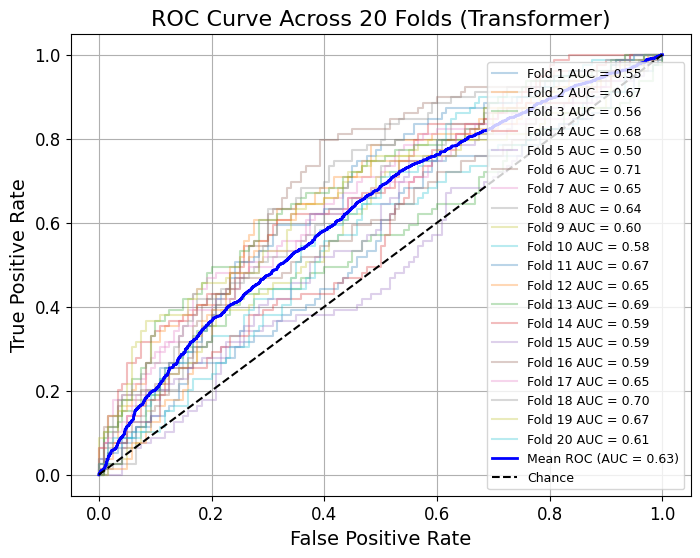

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

# Average ROC Curve
fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Across 20 Folds (Transformer)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)